<a href="https://colab.research.google.com/github/Shegy12/GAN-for-generating-artificial-ECG-data/blob/master/GANy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project description**

Generative Adversial Network for Artificial ECG Generation


# **Install python packages**

In [0]:
!pip3 install scipy keras
#!pip install mat73

# **Imports**

In [0]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import sys
import os
import datetime
from enum import Enum
from pathlib import Path

# numpy
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn

# Basics of Python data handling and visualization

import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.io as sio
from timeit import default_timer as timer


# **Google drive**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

GOOGLE_DRIVE_PATH = Path('/content/gdrive/My Drive')
WORKDIR = 'ECG_DATA' # specify the path to folder which you are intend to work with in this notebook
WORKDIR_PATH = GOOGLE_DRIVE_PATH / WORKDIR

if not os.path.exists(WORKDIR_PATH):
          os.mkdir(WORKDIR_PATH)

PosixPath('/content/gdrive/My Drive/ECG_DATA')

# **Paths**

In [0]:
#ANNOTATION - nazvy a anotacie/labely
ANNOTATION_PATH = WORKDIR_PATH / "annotFull.mat"
#MATDATA - signal database (.mat)
SINUS_PATH = WORKDIR_PATH / "SINUS"
AF_SV_VR_PATH = WORKDIR_PATH / "AF_SV_VR"
AB_AV_BB_PV_PATH = WORKDIR_PATH / "AB_AV_BB_PV"
OTHER_NOISY_PATH = WORKDIR_PATH / "OTHER_NOISY"


#**Data manipulation** (signals and labels)

In [0]:
matlab_data = sio.loadmat(file_name=ANNOTATION_PATH)
Ydata = matlab_data['YData']
print('Shape of Ydata ->' + str(Ydata.shape)+', 6884 = number of signals, 2 = signal_names,signal_labels')

signal_names = Ydata[:,0] 
signal_names = [str(signal_names).replace('[', '').replace("'", '').replace(']', '') for signal_names in signal_names.tolist()[:]]
#print('Number of signals ->' + str(len(signal_names)))
print('Names of signals ->' + str(signal_names))

signal_labels = Ydata[:,1]
#signal_labels = [str(signal_labels).replace('[', '').replace(']', '').replace(' ','') for signal_labels in signal_labels.tolist()[:]]
#print('Number of labels ->' + str(len(signal_labels)))
print('Signal labels ->' + str(signal_labels))

labels_names = matlab_data['annotLabel']
labels_names = [str(labels_names).replace('[', '').replace("'", '').replace(']', '').replace('', '') for labels_names in labels_names.tolist()[0]]
print('Names of labels ->' + str(labels_names))

# replace("'",'')


Shape of Ydata ->(6884, 2), 6884 = number of signals, 2 = signal_names,signal_labels
Names of signals ->['EB0000018570.mat', 'EB0000018571.mat', 'EB0000018572.mat', 'EB0000018573.mat', 'EB0000018574.mat', 'EB0000018575.mat', 'EB0000018576.mat', 'EB0000018577.mat', 'EB0000018578.mat', 'EB0000018579.mat', 'EB0000018580.mat', 'EB0000018581.mat', 'EB0000018582.mat', 'EB0000018583.mat', 'EB0000018584.mat', 'EB0000018585.mat', 'EB0000018586.mat', 'EB0000018587.mat', 'EB0000018588.mat', 'EB0000018589.mat', 'EB0000018590.mat', 'EB0000018591.mat', 'EB0000018592.mat', 'EB0000018593.mat', 'EB0000018594.mat', 'EB0000018595.mat', 'EB0000018596.mat', 'EB0000018597.mat', 'EB0000018598.mat', 'EB0000018599.mat', 'EB0000018600.mat', 'EB0000018601.mat', 'EB0000018602.mat', 'EB0000018603.mat', 'EB0000018604.mat', 'EB0000018605.mat', 'EB0000018606.mat', 'EB0000018607.mat', 'EB0000018608.mat', 'EB0000018609.mat', 'EB0000018610.mat', 'EB0000018611.mat', 'EB0000018612.mat', 'EB0000018613.mat', 'EB0000018614.m

# **Creating the database**

**Signaly1** = Signals with MANY types of labels including specific type of label

**Signaly2** = Signals with ONLY one type of label

In [0]:
AF1=[]; SI1=[];SV1=[];VR1=[];OT1=[];AV1=[];BB1=[];AB1=[];PV1=[];NO1=[]
AF2=[]; SI2=[];SV2=[];VR2=[];OT2=[];AV2=[];BB2=[];AB2=[];PV2=[];NO2=[]

def signal_type(i):
  switcher={
      0:AF2,1:SI2,2:SV2,3:VR2,4:OT2,5:AV2,6:BB2,7:AB2,8:PV2,9:NO2,
      10:AF1,11:SI1,12:SV1,13:VR1,14:OT1,15:AV1,16:BB1,17:AB1,18:PV1,19:NO1
    }
  return switcher.get(i,"Invalid number of label")


prefix=['AF2','SI2','SV2','VR2','OT2','AV2','BB2','AB2','PV2','NO1','AF1','SI1','SV1','VR1','OT1','AV1','BB1','AB1','PV1','NO1']

for counter in range(10,20):
  for item in Ydata.tolist():
    if list(item[1][0])[counter-10] == 1:
      signal_type(counter).append(str(prefix[counter])+str(item[0]).replace('[', '').replace("'", '').replace(']', ''))


print('Signals with MANY types of labels including specific type of label:')
print('')
print('Number of AF1 signals ->' + str(len(signal_type(10))))
print('Number of SI1 signals ->' + str(len(signal_type(11))))
print('Number of SV1 signals ->' + str(len(signal_type(12))))
print('Number of VR1 signals ->' + str(len(signal_type(13))))
print('Number of OT1 signals ->' + str(len(signal_type(14))))
print('Number of AV1 signals ->' + str(len(signal_type(15))))
print('Number of BB1 signals ->' + str(len(signal_type(16))))
print('Number of AB1 signals ->' + str(len(signal_type(17))))
print('Number of PV1 signals ->' + str(len(signal_type(18))))
print('Number of NO1 signals ->' + str(len(signal_type(19))))
print('')

counter=0
for counter in range(10):
  for item in Ydata.tolist():
    if list(item[1][0])[counter] == 1 and sum(list(item[1][0])) < 2:
      signal_type(counter).append(str(prefix[counter])+str(item[0]).replace('[', '').replace("'", '').replace(']', ''))

print('Signals with ONLY one type of label:')
print('')
print('Number of AF2 signals ->' + str(len(signal_type(0))))
print('Number of SI2 signals ->' + str(len(signal_type(1))))
print('Number of SV2 signals ->' + str(len(signal_type(2))))
print('Number of VR2 signals ->' + str(len(signal_type(3))))
print('Number of OT2 signals ->' + str(len(signal_type(4))))
print('Number of AV2 signals ->' + str(len(signal_type(5))))
print('Number of BB2 signals ->' + str(len(signal_type(6))))
print('Number of AB2 signals ->' + str(len(signal_type(7))))
print('Number of PV2 signals ->' + str(len(signal_type(8))))
print('Number of NO2 signals ->' + str(len(signal_type(9))))
print('')

print('Database of signals was created.')

Signals with MANY types of labels including specific type of label:

Number of AF1 signals ->553
Number of SI1 signals ->5942
Number of SV1 signals ->194
Number of VR1 signals ->102
Number of OT1 signals ->88
Number of AV1 signals ->250
Number of BB1 signals ->434
Number of AB1 signals ->418
Number of PV1 signals ->413
Number of NO1 signals ->2183

Signals with ONLY one type of label:

Number of AF2 signals ->267
Number of SI2 signals ->3350
Number of SV2 signals ->89
Number of VR2 signals ->69
Number of OT2 signals ->5
Number of AV2 signals ->0
Number of BB2 signals ->0
Number of AB2 signals ->0
Number of PV2 signals ->0
Number of NO2 signals ->69

Database of signals was created.


#**Signal loading and visualising**

### Problem 1:
Neither scipy.io.savemat, nor scipy.io.loadmat work for MATLAB arrays version 7.3. But the good part is that MATLAB version 7.3 files are hdf5 datasets. So they can be read using a number of tools, including NumPy.

For Python, you will need the h5py extension, which requires HDF5 on your system.

### Solution 1:
Create new database in Matlab (save new .mat files and upload to cloud).
New .mat files were created, 5000samples, 3 columns (II,avR,avL). Also re-work previous cell (names of .mat files are now different)- DONE. We will be working with this as input.

##Lead II

Text(0, 0.5, 'Amplitude [μV]')

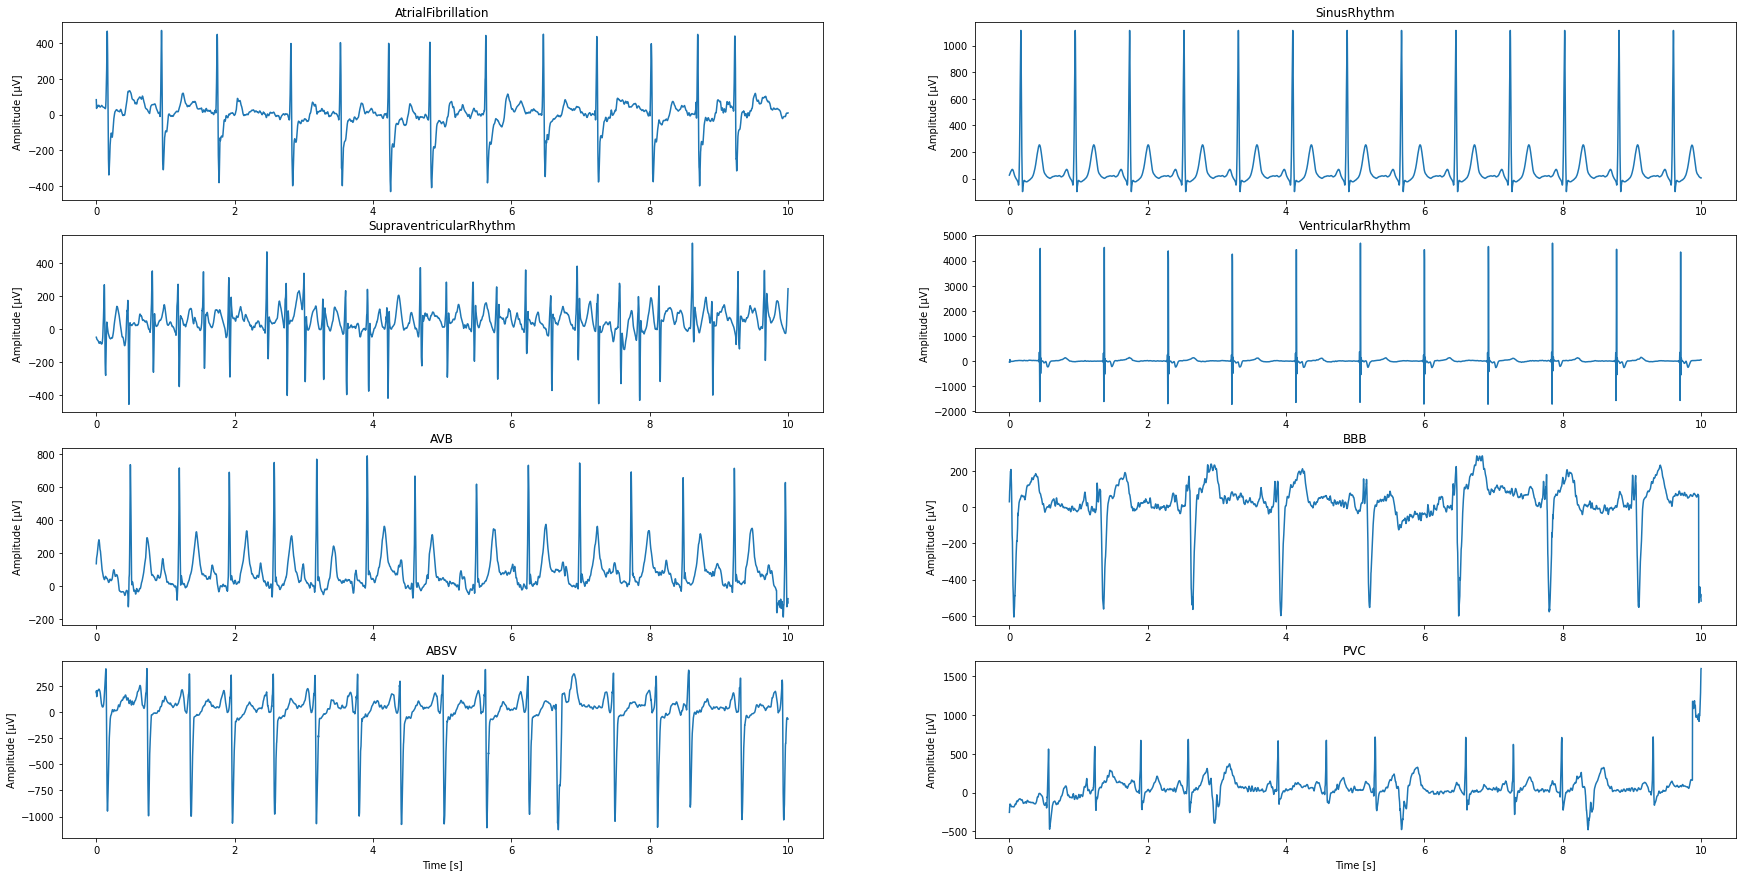

In [0]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,0]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,0]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,0]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,0]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,0]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,0]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,0]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,0]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')


##AvR

In [0]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,1]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,1]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,1]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,1]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,1]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,1]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,1]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,1]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')



array([-237,  189,  -15], dtype=int16)

##avL

In [0]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,2]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,2]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,2]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,2]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,2]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,2]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,2]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,2]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')

type(AF2_signal[:,0])


array([ 113,  112,  112, ..., -196, -179, -163], dtype=int16)

#**Signal loading 2.0**

In [0]:
AF2_II=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_II.append(signal[:,0])

AF2_II=np.asarray(AF2_II)

print(np.shape(AF2_II))

AF2_avR=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_avR.append(signal[:,1])

AF2_avR=np.asarray(AF2_avR)
print(np.shape(AF2_avR))

AF2_avL=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_avL.append(signal[:,2])

AF2_avL=np.asarray(AF2_avL)

print(np.shape(AF2_avL))

labels=np.ones((len(AF2),1))

print(np.shape(labels))

(267, 5000)
(267, 5000)
(267, 5000)
(267, 1)


# **EKG CLANOK.pdf**

* The **input to the generator** comprises a **series of sequences where each sequence is made of 3120 noise points.** The **output is a generated ECG sequence with a length that is also set to 3120.**

*  The **input to the discriminator is the generated result and the real ECG data,** and the **output is D(x) ∈ {0, 1}.** 

* Inspired by their work, in our research, **each point sampled from ECG is denoted by a one-dimensional vector of the time-step and leads.**

* We used the MIT-BIH arrhythmia data set provided by the Massachusetts Institute of Technology for studying arrhythmia in our experiments. We downloaded 48 individual records for training. Each record comprised three files, i.e., the header file, data file, and annotation file. Each data file contained about 30 minutes of ECG data. In each record, a **single ECG data point comprised two types of lead values; in this work, we only selected one lead signal for training**

##Loading

In [0]:
# load real samples of sinus rhythm
SI2_II=[]
for i in range(len(SI2)):
  SI2_PATH=SINUS_PATH / SI2[i]
  signal=sio.loadmat(SI2_PATH)
  signal=signal['data']
  SI2_II.append(signal[0:3120,0])

SI2_II=np.asarray(SI2_II)
print(np.shape(SI2_II))
np.save(WORKDIR_PATH / "SI2_II",SI2_II)


(3350, 3120)


## Discriminator

* The sequence comprising ECG data points can be regarded as a time series sequence (a normal image requires both a vertical convolution and a horizontal convolution) rather than an image, so only one-dimensional **(1-D) convolution** need to be involved.

* We assume that an input sequence x1, x2, … xT comprises T points, where each is represented by a d-dimensional vector. (xT*d)?

* After conducting double pairs of operations for convolution and pooling, we add a fully connected layer that connects to a softmax layer, where the output is a one-hot vector.** The two elements in the vector represent the probability that the input is true or false.**

* With pairs of convolution-pooling operations, we get the output size as 5*10*1. A fully connected layer which contains 25 neurons connects with P2. The last layer is the softmax-output layer, which outputs the judgement of the discriminator. 

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 601, 10)           1210      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 186, 10)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 51, 5)             1805      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 5)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

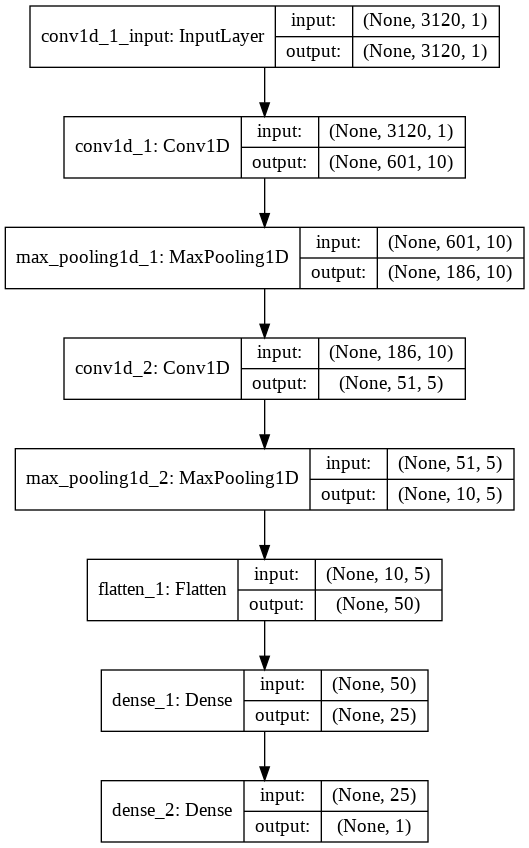

In [0]:
#keras
from keras.models import Sequential
from keras.layers import Conv1D, TimeDistributed, MaxPooling1D, Dense, Softmax, Flatten, LeakyReLU, Activation
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam

#nema byt vstup 3120,2 ? predsa tam vstupuje aj real aj fake vzorka naraz nie?

def define_discriminator(input_shape=(3120,1)):
  model = Sequential()
  model.add(Conv1D(input_shape=input_shape, filters=10, kernel_size=120, strides=5, padding='valid', data_format='channels_last', dilation_rate=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
  model.add(MaxPooling1D(pool_size=46, strides=3, padding='valid', data_format='channels_last'))
  model.add(Conv1D(filters=5, kernel_size=36, strides=3, padding='valid', data_format='channels_last', dilation_rate=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
  model.add(MaxPooling1D(pool_size=24, strides=3, padding='valid', data_format='channels_last'))
  #flatten layer added for proper function
  model.add(Flatten())
  model.add(Dense(25, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
  model.add(Dense(1, activation='softmax'))
  # compile model
  # oni pouzivaly asi SGD a mini-batch o dlzke 100, adam je ale lepsi
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
  return model


#super-tuned model

#1. Use Strided Convolutions - how?
#2. Use Batch Normalization - how?

#3. Remove Fully-Connected Layers - done
#4. Use ReLU, Leaky ReLU, and Tanh - done
#5. Use Adam Optimization - done

# def define_discriminator(input_shape=(3120,1)):
#   model = Sequential()
#   model.add(Conv1D(input_shape=(3120,1),filters=10, kernel_size=120, strides=5, padding='valid', data_format='channels_last', dilation_rate=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
#   model.add(LeakyReLU(alpha=0.2))
#   model.add(MaxPooling1D(pool_size=46, strides=3, padding='valid', data_format='channels_last'))
#   model.add(Conv1D(filters=5, kernel_size=36, strides=3, padding='valid', data_format='channels_last', dilation_rate=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
#   model.add(LeakyReLU(alpha=0.2))
#   model.add(MaxPooling1D(pool_size=24, strides=3, padding='valid', data_format='channels_last'))
#   model.add(Flatten())
#   model.add(Dense(1, activation='softmax'))
#   # compile model
#   model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
#   return model

# define the discriminator model
discriminator_model = define_discriminator()
# summarize the model
discriminator_model.summary()
# plot the model
plot_model(discriminator_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## Generator

*  series of noise data points that follow a Gaussian distribution are fed into the generator as a fixed length sequence. We assume that each noise point can be represented as a d-dimensional one-hot vector and the length of the sequence is T. Thus, the size of the input matrix is T × d. 

* The generator comprises two BiLSTM layers, each having 100 cells. 

* A dropout layer is combined with a fully connected layer. 

* To prevent slow gradient descent due to parameter inflation in the generator, we add a dropout layer and set the probability to 0.5. 

* The output layer is a two-dimensional vector where the first element represents the time step and the second element denotes the lead. ??????????????**??? akoze 3120x1 lead alebo myslia 3120x2 (cas a 1 lead)**

* The generator produces data based on the noise data sampled from a Gaussian distribution, which is **fitted to the real data distribution as accurately as possible.** The inputs for the discriminator are real data and the results produced by the generator, where the aim is to determine whether the input data are real or fake.


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 3120, 100)         84800     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 3120, 100)         160800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 3120, 100)         0         
_________________________________________________________________
dense_10 (Dense)             (None, 3120, 1)           101       
Total params: 245,701
Trainable params: 245,701
Non-trainable params: 0
_________________________________________________________________


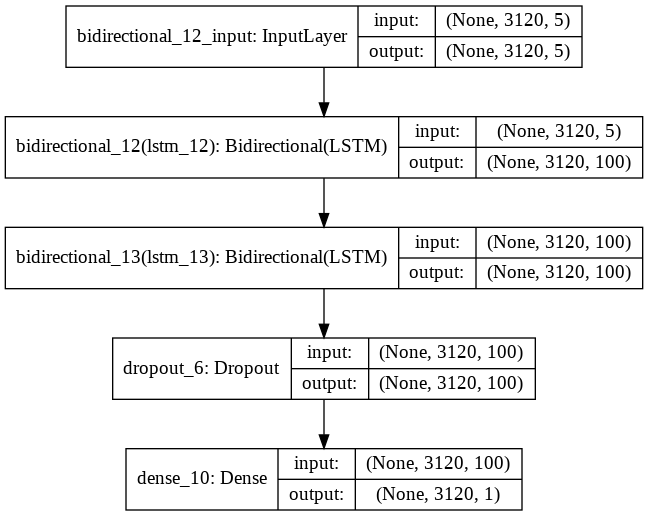

In [0]:
from keras.layers import Dense, Dropout, LSTM, Bidirectional

# define the standalone generator model
def define_generator(latent_dim, n_outputs=1):
  model = Sequential()
  #model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
  model.add(Bidirectional(LSTM(100, return_sequences=True),
                          input_shape=(3120,latent_dim), merge_mode='sum'))
  model.add(Bidirectional(LSTM(100, return_sequences=True),merge_mode='sum'))
  model.add(Dropout(0.5, noise_shape=None, seed=None))
  
  # The output layer is a two-dimensional vector where the first element represents the time step and the second element denotes the lead.
  model.add(Dense(n_outputs))
  return model


# size of the latent space
latent_dim = 5
# define the generator model
generator_model = define_generator(latent_dim)
# summarize the model
generator_model.summary()
# plot the model
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)


##GAN

Gan model summary :
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_12 (Sequential)   (None, 3120, 1)           245701    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 4316      
Total params: 250,017
Trainable params: 245,701
Non-trainable params: 4,316
_________________________________________________________________
Gan model plot: 


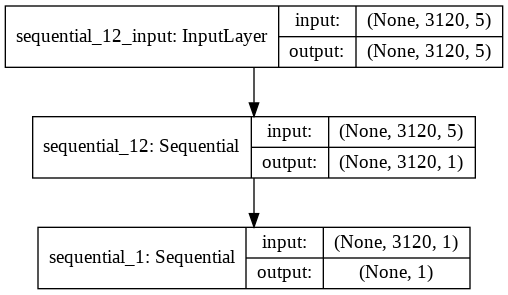

In [378]:
from keras.optimizers import Adam

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model


# create the gan
gan_model = define_gan(generator_model, discriminator_model)
# summarize gan model
print('Gan model summary :')
gan_model.summary()
# plot gan model
print('Gan model plot: ')
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

## Possible tuning


### https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

*     Normalize inputs to the range [-1, 1] and use tanh in the generator output.
*   Flip the labels and loss function when training the generator.
*   Sample Gaussian random numbers as input to the generator.
*   Use mini batches of all real or all fake for calculating batch norm statistics.
*   Use Leaky ReLU in the generator and discriminator.
*   Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling.
*   Use label smoothing in the discriminator, with small random noise.
*   Add random noise to the labels in the discriminator.
*   Use DCGAN architecture, unless you have a good reason not to.
*   A loss of 0.0 in the discriminator is a failure mode.
*   If loss of the generator steadily decreases, it is likely fooling the discriminator with garbage images.
*   Use labels if you have them.
*   Add noise to inputs to the discriminator and decay the noise over time.
*   Use dropout of 50 percent during train and generation.

### T81-558: Applications of Deep Neural Networks¶

https://github.com/jeffheaton/t81_558_deep_learning/blob/c889939162c17d475dfe6dc37b5440d21293acdb/t81_558_class_07_2_Keras_gan.ipynb


* No pre-processing was applied to training images besides scaling to the range of the tanh activation function [-1, 1].
* All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128.
* All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.
* In the LeakyReLU, the slope of the leak was set to 0.2 in all models.
* We used the Adam optimizer(Kingma & Ba, 2014) with tuned hyperparameters.
  * We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead.
  * Additionally, we found leaving the momentum term $\beta{1}$ at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.




## Training

*  Each model was trained for 500 epochs with a batch size of 100, where the length of the sequence comprised a series of ECG 3120 points and the learning rate was 1 × 10−5. 

*  The dim for the noise data points was set to 5 and the length of the generated ECGs was 400. 

* It is well known that under normal circumstances, the average heart rate is 60 to 100 in a second. Therefore, the normal cardiac cycle time is between 0.6 s to 1 s. Based on the sampling rate of the MIT-BIH, the calculated length of a generated ECG cycle is between 210 and 360. Figure 8 shows the results of RMSE and FD by different specified lengths from 50–400. From Fig. 8, we can conclude that the quality of generation is optimal when the generated length is 250 (RMSE: 0.257, FD: 0.728). 

In [384]:
import random

# SI2_II=np.load(WORKDIR_PATH / "SI2_II.npy") #3350,3120 shape

length_of_signal=3120
number_of_signals=3350
#SI2_II=np.transpose(SI2_II)


time_axis=np.linspace(0,length_of_signal/500,length_of_signal)
avg_max=int(np.round(np.mean(np.amax(SI2_II, axis=0))))
avg_min=int(np.round(np.mean(np.amin(SI2_II, axis=0))))
signals_mean=np.mean(np.mean(SI2_II, axis=0))
signals_std=np.std(np.std(SI2_II, axis=0))

# print('Shape of SI2')
# print (np.shape(SI2_II))
# print('3120 samples, 3350 signals')
# print('Length of signals :')
# print(str(length_of_signal))
# print('Time axis :')
# print(time_axis)
# print('time axis length is :' + str(len(time_axis)))
# print('Mean of max :')
# print(avg_max)  
# print('Mean of min :')
# print(avg_min)
# print('Mean of signals :')
# print(signals_mean)
# print('Std of signals :')
# print(signals_std)    


# generate points in latent space as input for the generator
# vygenerujem randon seedy 3120x5 kazdy seed je v rozmedzi <min,max> signalu sinus II
# este upravit aby random seedy boli gaussovsky rozlozene

def generate_latent_points(latent_dim,length_of_signal):
  # generate points in the latent space
  # Option 1

  x_input = np.random.normal(signals_mean,signals_std, size=(length_of_signal, latent_dim))
  return x_input

def generate_latent_points2(latent_dim,length_of_signal):
  # generate points in the latent space
  #Option 2

  #print('Max of max :')
  noise_max=np.amax(np.amax(x_input, axis=0))
  #print(noise_max)  
  #print('Min of min :')
  noise_min=np.amin(np.amin(x_input, axis=0))
  #print(noise_min)
  x_input2=(x_input-noise_min)/(noise_max-noise_min)*(avg_max-avg_min)+avg_min 
  return x_input2

#print(np.shape(x_input))
#print(np.shape(X))
#print(type(X))
#print(np.shape(X_fake))
#print (np.shape(SI2_II))
#print(np.shape(real_data))
#print(np.shape(fake_data))

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, batch_size):
  # generate points in latent space
  x_input=[]
  X=[]
  for i in range (batch_size):
    X = generate_latent_points(latent_dim, length_of_signal)
    x_input.append(X)
  x_input=np.asarray(x_input)
  # predict outputs
  X = generator.predict(x_input)
  # create class labels
  # nemali by to byt jednotky?????
  y = np.zeros((batch_size, 1))
  return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples2(generator, latent_dim, batch_size):
  # generate points in latent space
  x_input=[]
  X=[]
  for i in range (batch_size):
    X = generate_latent_points2(latent_dim, length_of_signal)
    x_input.append(X)
  x_input=np.asarray(x_input)
  # predict outputs
  X = generator.predict(x_input)
  # create class labels
  # nemali by to byt jednotky?????
  y = np.zeros((batch_size, 1))
  return X, y

# batch_size=10
def generate_real_samples(batch_size):
  X=[]
  for i in range (batch_size):
    cislo_signalu=random.randint(0, number_of_signals-1)
    X.append(SI2_II[:,cislo_signalu])
  X=np.asarray(X)
  X=X.reshape(batch_size,length_of_signal,1)
  y = np.ones((batch_size,1))
  #y = y.reshape(1,length_of_signal,1)
  return X, y


latent_space=generate_latent_points(latent_dim,length_of_signal)
# plot samples
plt.plot(time_axis, latent_space[:,0])
pyplot.title('Latent space method 1') 
pyplot.show()

latent_space2=generate_latent_points2(latent_dim,length_of_signal)
# plot samples
plt.plot(time_axis, latent_space2[:,0])
pyplot.title('Latent space method 2')
pyplot.show()

# generate fake samples
fake_data,y = generate_fake_samples(generator, latent_dim, 1) 
# plot samples
plt.plot(time_axis, fake_data[0])
pyplot.title('Random Fake samples method 1') 
pyplot.show()

# generate fake samples2
fake_data2,y2 = generate_fake_samples2(generator, latent_dim, 1) 
# plot samples
plt.plot(time_axis, fake_data2[0])
pyplot.title('Random Fake samples method2') 
pyplot.show()

# generate samples
real_data,y = generate_real_samples(1)
# plot samples
plt.plot(time_axis, real_data[0])
pyplot.title('Random Real samples') 
pyplot.show()


(3120, 5)


### As the generator has not been trained, the generated points are complete rubbish, as we expect, but we can imagine that as the model is trained, these points will slowly begin to resemble signal.

## Training the discriminator

In [0]:
# train the discriminator model
def train_discriminator(model, n_epochs=500, n_batch=100):
	half_batch = int(n_batch / 2)
	# run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
		# generate fake examples
		X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)
		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
		print(i, acc_real, acc_fake)
  
# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model)

## Training the generator

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space, generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a logical third model that uses the already-defined layers and weights from the standalone generator and discriminator models.

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this subsumed GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.

In [0]:
from keras.optimizers import Adam

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model


# create the gan
gan_model = define_gan(generator_model, discriminator_model)
# summarize gan model
print('Gan model summary :')
gan_model.summary()
# plot gan model
print('Gan model plot: ')
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

# # train the composite model
# def train_gan(gan_model, latent_dim, n_epochs=500, batch_size):
# 	# manually enumerate epochs
# 	for i in range(n_epochs):
# 		# prepare points in latent space as input for the generator
# 		x_gan = generate_latent_points(latent_dim, batch_size)
# 		# create inverted labels for the fake samples
# 		y_gan = ones((batch_size, 1))
# 		# update the generator via the discriminator's error
# 		gan_model.train_on_batch(x_gan, y_gan)

## Training GAN

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 1.0 0.0


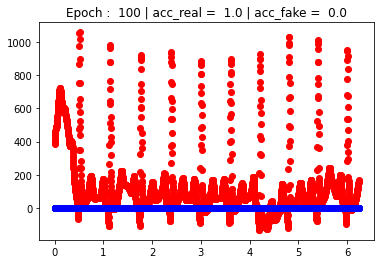

100 1.0 0.0


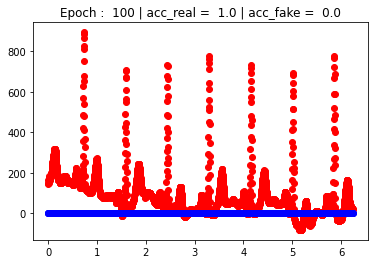

100 1.0 0.0


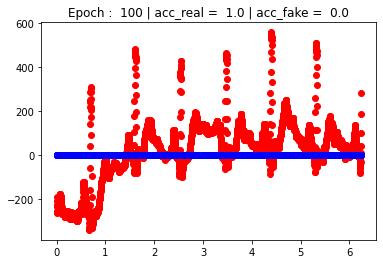

100 1.0 0.0


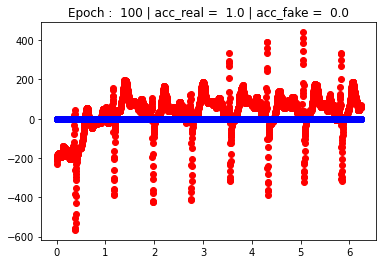

100 1.0 0.0


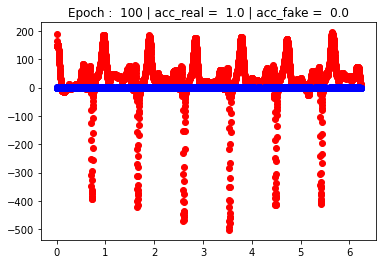

100 1.0 0.0


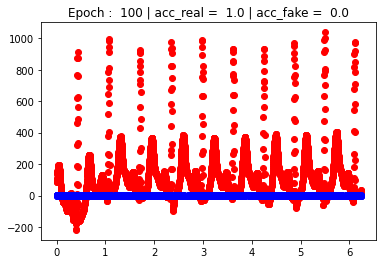

100 1.0 0.0


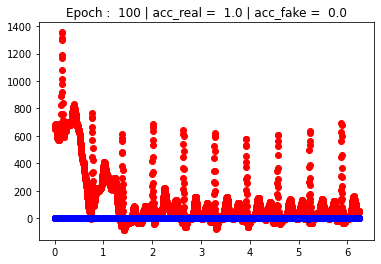

100 1.0 0.0


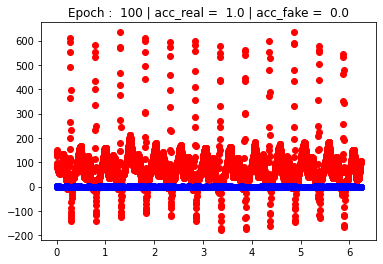

100 1.0 0.0


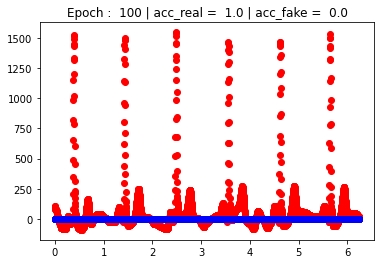

100 1.0 0.0


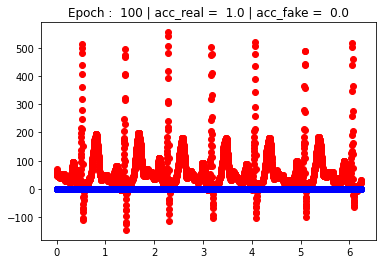

100 1.0 0.0


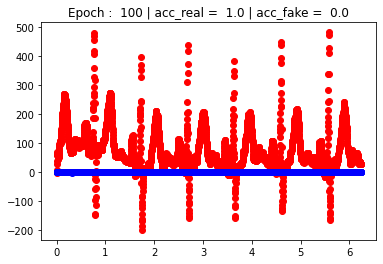

100 1.0 0.0


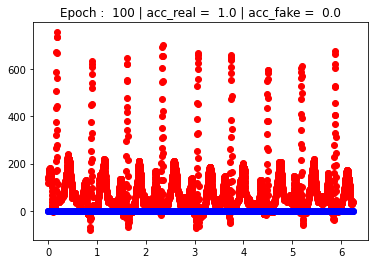

100 1.0 0.0


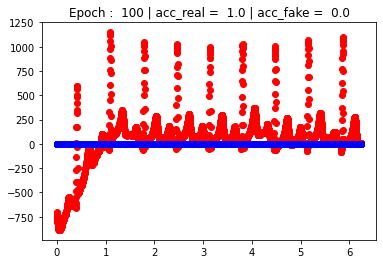

100 1.0 0.0


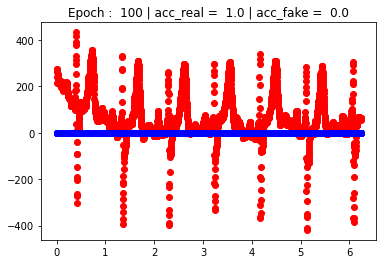

100 1.0 0.0


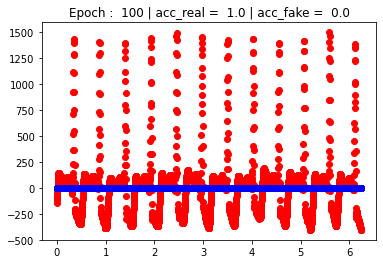

100 1.0 0.0


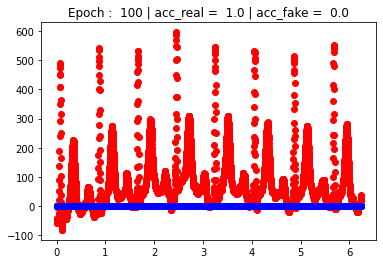

KeyboardInterrupt: ignored

In [387]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, batch_size):
  half_batch = int(n_batch / 2)
  # prepare real samples 
  X_real, y_real = generate_real_samples(half_batch)
  # evaluate discriminator on real examples
  _, acc_real = model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
  # evaluate discriminator on fake examples
  _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
  pyplot.scatter(time_axis, X_real[0], color='red')
  pyplot.scatter(time_axis, X_fake[0], color='blue')
  pyplot.title('Epoch :'+ "  " + str(epoch)+" | "+'acc_real ='+"  "+str(acc_real)+" | "+'acc_fake ='+"  "+str(acc_fake))
  pyplot.show()

  #if (acc_fake > 0.475) and (acc_fake < 0.525) and (acc_real > 0.475) and (acc_real < 0.525):
    #print('Model is trained')
    #a=1/0

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=500, batch_size=100, n_eval=10): #batchsize kludne zvacsit
  #determine half the size of one batch, for updating the discriminator
  half_batch = int(batch_size / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)
    # prepare points in latent space as input for the generator
    x_gan=[]
    for i in range (batch_size):
      X = generate_latent_points(latent_dim, length_of_signal)
      x_gan.append(X)
    x_gan=np.asarray(x_gan)
    # create inverted labels for the fake samples
    y_gan = np.ones((batch_size, 1))
    # update the generator via the discriminator's error
    gan_model.train_on_batch(x_gan, y_gan)
    # evaluate the model every n_eval epochs
    if (i+1) % n_eval == 0:
      summarize_performance(i+1, g_model, d_model, latent_dim,batch_size)


# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim,1)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)


#end = timer()
#print(end - start) # Time in seconds, e.g. 5.38091952400282

# nastavit zastavenie ked bude acc 50/50 alebo nejak to proste optimalizovat?

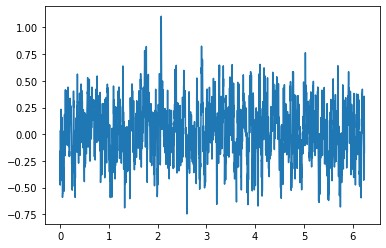

In [388]:
x_fake, y_fake = generate_fake_samples(generator, 5, 400)
plt.plot(time_axis, x_fake[0])
pyplot.show()

# **Quick and eazy time series generation with Established Image-based GAN**


**Publication :**

https://www.researchgate.net/publication/331165358_Quick_and_Easy_Time_Series_Generation_with_Established_Image-based_GANs

## Imports

In [0]:
#keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

## Pre-processing of 1D signals ---> images 64x64

In [0]:
#vytvorit 64x64 obrazky z 1D signalov
#aka transformacia?

In [0]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher will blow Google CoLab's memory and have not been tested extensivly.

GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 1 #3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/My Drive/projects/faces'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

#training_dat=np.load..........

#We will use a TensorFlow Dataset object to actually hold the images. This allows the data to be quickly shuffled int divided into the appropriate batch sizes for training.

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



## Generator and Discriminator architectures

In [0]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

## Save the images 

In [0]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] 
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

## Generate random noise image

In [0]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

## Define Discriminator

In [0]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

## Define losses and optimizers

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

## Training

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [0]:
train(train_dataset, EPOCHS)

## Save the generator and generate

In [0]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))

In [0]:
#random seed/latents space demonstration, latent space=5
latent_space=5
x_input = randn(latent_space * 3120) 
print(len(x_input))
x_input = x_input.reshape(3120, latent_space)
print(np.shape(x_input))
print(x_input[500])